# Case Study 1 : Collecting Data from Twitter

Due Date: September 21, **BEFORE the beginning of class at 6:00pm**

## **NOTE: There are *always* last minute issues submitting the case studies.  DO NOT WAIT UNTIL THE LAST MINUTE!**

* ------------

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/9f/Twitter_bird_logo_2012.svg/220px-Twitter_bird_logo_2012.svg.png">

**TEAM 12 Members:** 

    Chu Wang
    Saranya Manoharan
    Rishitha Kiran
    You Di
    Valerie Tuzel
    
   

**Required Readings:** 
* Chapter 1 and Chapter 9 of the book [Mining the Social Web](http://www.learndatasci.com/wp-content/uploads/2015/08/Mining-the-Social-Web-2nd-Edition.pdf) 
* The codes for [Chapter 1](http://bit.ly/1qCtMrr) and [Chapter 9](http://bit.ly/1u7eP33)


** NOTE **
* Please don't forget to save the notebook frequently when working in IPython Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem 1: Sampling Twitter Data with Streaming API about a certain topic

* Select a topic that you are interested in, for example, "WPI" or "Lady Gaga"
* Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million.
* Store the tweets you downloaded into a local file (txt file or json file) 

In [24]:
import twitter
import sys
import io
import json
import os
#---------------------------------------------
# Define a Function to Login Twitter API
def oauth_login():
    # Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'Z7lkIGSYOQ7V2oz1V9Z2JSKnR'
    CONSUMER_SECRET ='Wahjl2NWnkPpogbKw8JpPSTKkBTMX63yf0lYCfzSRwsOMgitOk'
    #OAUTH_TOKEN = '571213367-jAEYPDKJy2T6PjrqmmAsxF6Bq1uJ8s0ADed1kqae'
    OAUTH_TOKEN = '773982098256519173-38xCfCLocB5Pp0KQT0sPmk9wv728Kc5'
    OAUTH_TOKEN_SECRET = 'TmhZcvgEf030QdrKe9yVjaZjzyKrQveJYwTmkKiDbHLSg'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

twitter_api = oauth_login()
# displaying twitter_api to make sure that it's now a defined variable
print(twitter_api)


In [ ]:
# DATA Collection- DO NOT RUN AGAIN
#Common Function to make Requests
import sys
import time
#from urllib2 import URLError
from urllib.error import URLError
#from httplib import BadStatusLine
from http.client import BadStatusLine
import json
import twitter

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print >> sys.stderr, 'Too many retries. Quitting.'
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print >> sys.stderr, 'Encountered 401 Error (Not Authorized)'
            return None
        elif e.e.code == 404:
            print >> sys.stderr, 'Encountered 404 Error (Not Found)'
            return None
        elif e.e.code == 429: 
            print >> sys.stderr, 'Encountered 429 Error (Rate Limit Exceeded)'
            if sleep_when_rate_limited:
                print >> sys.stderr, "Retrying in 15 minutes...ZzZ..."
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print >> sys.stderr, '...ZzZ...Awake now and trying again.'
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print >> sys.stderr, 'Encountered %i Error. Retrying in %i seconds' % \
                (e.e.code, wait_period)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "URLError encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
                
twitter_stream = twitter.TwitterStream(auth=twitter_api.auth)
#stream = twitter_stream.statuses.filter(track=q1 or q2 or q3 or q4 or q5 or q6)
#q = 'Junk Food'
q = 'ryanair'
out_file_name_prefix = 'ual_'
#q = 'iphone'
#stream = twitter_stream.statuses.filter(track = q1)
stream = make_twitter_request(twitter_stream.statuses.filter,
                            track=q)

# store the tweeets you downloaded into a json file(can not store the text without english)
file_cnt = 1
total_records = 0
records_list = []
try:
    for tweet in stream:
        total_records += 1
        print('get records, total:', total_records)
        records_list.append(tweet)
        if total_records % 1000 == 0:
            file_name = out_file_name_prefix + str(file_cnt) + '.data'
            with open(file_name, 'w') as f:
                f.write(json.dumps(records_list, indent=4))
            print('write %d records to file %s.....' % (len(records_list), file_name))
            file_cnt += 1
            records_list = []
        if total_records == 10000:
            break
except KeyboardInterrupt as e:
    print('process remain data')
    if len(records_list) != 0:
        file_name = out_file_name_prefix + str(file_cnt) + '.data'
        with open(file_name, 'w') as f:
            f.write(json.dumps(records_list, indent=4))
        print('last write %d records to file %s.....' % (len(records_list), file_name))
    else:
        print('no remain data')
else:
    print('success done')

In [19]:
import json
file = open('ryanair_6000.txt','r')
ryanair = file.read()
statuses = json.loads(ryanair)
print(str("Total number of tweets collected: "),len(statuses),"\n")
print(statuses[0].keys())

Total number of tweets collected:  6000 

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'])


## Report some statistics about the tweets you collected¶
•The topic of interest: RYANAIR

•The total number of tweets collected: 6000



# Problem 2: Analyzing Tweets and Tweet Entities with Frequency Analysis

**1. Word Count:** 
* Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets. 
* Plot a table of the top 30 words with their counts

In [27]:
import string
print(str.maketrans('','',string.punctuation))  


{33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None}


In [21]:
import re
from collections import Counter
from prettytable import PrettyTable
import nltk
import string


tweet_texts = [ tweet['text'] 
                 for tweet in statuses
                      if tweet["lang"] == "en" ]
words = [ word 
          for tweet in tweet_texts
             for word in tweet.strip().split()
                if word not in ['RT', '&amp;']  # filter out RT and ampersand
        ]

#clear = translator(delete=string.)
#cleanwords = [w.clear() for w.strip() in words ]

# Use the natural language toolkit to eliminate stop words
nltk.download('stopwords')

def stop_words():
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words += [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','🙄…']
    stop_words += list(string.punctuation)
    return stop_words 
 
hashtag_set = set()
for tweet in statuses:
    if "entities" in tweet.keys() and len(tweet["entities"])!=0 :
        if "hashtags" in tweet["entities"] and len(tweet["entities"]["hashtags"])!=0:
            for hashtag in tweet["entities"]["hashtags"]:
                hashtag_set.add(hashtag["text"])
                #hashtag_list[hashtag["text"]] = hashtag_list.get(hashtag["text"])

stop_words = stop_words()
content_words = [w for w in words if not w.startswith(('https:','http','@','#','0','1','2','3','4','5','6','7','8','9')) ]
clean_words = [ w.translate(str.maketrans('','',string.punctuation)) for w in content_words ]
lower_words = [w.lower() for w in clean_words]
pure_words = [w.strip() for w in lower_words if w.strip()!='']
popular_words = [w for w in pure_words if w.lower() not in stop_words]
non_stop_words = [w for w in popular_words if w.lower() not in hashtag_set]

# frequency of words
count = Counter(non_stop_words).most_common()

# table of the top 30 words with their counts
print("\n")
print(str("Top 30 Words With Their Counts:"),"\n")

pretty_table = PrettyTable(field_names=['Word', 'Count']) 
[ pretty_table.add_row(w) for w in count[:30] ]
pretty_table.align['Word'] = 'l'
pretty_table.align['Count'] = 'r'
print(pretty_table)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/htuzel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 30 Words With Their Counts: 

+---------------+-------+
| Word          | Count |
+---------------+-------+
| cancelled     |   736 |
| list          |   337 |
| cancels       |   313 |
| next          |   302 |
| get           |   257 |
| day           |   256 |
| pilots        |   219 |
| cancellations |   216 |
| know          |   215 |
| rights        |   185 |
| leave         |   183 |
| cancelling    |   180 |
| people        |   173 |
| dont          |   171 |
| messing       |   170 |
| days          |   167 |
| weeks         |   166 |
| entitled      |   159 |
| full          |   158 |
| losing        |   156 |
| us            |   150 |
| brexit        |   149 |
| forget        |   147 |
| workers       |   146 |
| annual        |   141 |
| customers     |   138 |
| talk          |   138 |
| going         |   127 |
| please       

## 2. Find the most popular tweets in your collection of tweets

Please plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.


In [20]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

#function to count the tweets with maximum retweets
def popular_tweets_count(statuses):
    popular = {}
    for tweet in statuses:
        if "retweeted_status" in tweet.keys() and len(tweet["retweeted_status"])!=0	and tweet["lang"] == "en" \
            and "retweet_count" in tweet["retweeted_status"].keys():
                if tweet["retweeted_status"]["retweet_count"] != 0 and "text" in tweet.keys() and len(tweet["text"])!=0:
                    #to make sure same tweet doesn't go into the list more than once
                    if tweet["text"] not in popular.values(): 
                        popular[tweet["retweeted_status"]["retweet_count"]] = tweet["text"]
    # sort the most popular tweets and extract the top 10                    
    sorted_popular = sorted(popular.items(), key=lambda t: t[0], reverse = True)[:10]
    #return top 10 tweets
    return sorted_popular

#get the top 10 tweets
popular_tweets_count = popular_tweets_count(statuses)
#for tweet in sorted(popular_tweets_count, reverse=True):
    #print("Retweeted_count: ", tweet[0], "\t","Tweet_text: ", tweet[1])

print(str("Top 10 Tweets:"),"\n")
table = PrettyTable(field_names=['Count', 'Text'])
[ table.add_row(row) for row in sorted (popular_tweets_count, reverse=True)]
table.max_width['Text'] = 60
table.align= 'l'
print(table)


Top 10 Tweets: 

+-------+--------------------------------------------------------------+
| Count | Text                                                         |
+-------+--------------------------------------------------------------+
| 1062  | RT @Ryanair: For a chance to WIN a €/£100 voucher simply     |
|       | FOLLOW, RETWEET &amp; tell us which destination you stopped  |
|       | on below using…                                              |
| 434   | RT @Channel4Racing: VAUTOUR with @Ruby_Walsh on board finds  |
|       | an extra gear to win the Ryanair Chase! #CheltenhamFestival  |
|       | https://t.co/ezSqhc…                                         |
| 136   | RT @LeaveEUOfficial: When you talk about losing workers'     |
|       | rights after Brexit but forget your pilots are entitled to   |
|       | annual leave... 🙄…                                           |
| 135   | RT @PaulWoolford: How is it legal that @Ryanair can cancel   |
|       | 400,000 seats on it's fl

**3. Find the most popular Tweet Entities in your collection of tweets**

Please plot a table of the top 10 hashtags, top 10 user mentions that are the most popular in your collection of tweets.

In [22]:
import twitter
import sys
import io
import json
import os
from prettytable import PrettyTable

#function to get the top 10 hashtags
#check that the entities in a tweet are not empty, then check if it has hashtags
#for each hash tag in a tweet add the hashtag and count into the list ,increment the count accordingly
#sort the list of hashtags in decreasing order and extract the top 10 
#return the top 10 hash tags
def top_hashtag(statuses):
    hashtag_list ={}
    for tweet in statuses:
        if "entities" in tweet.keys() and len(tweet["entities"])!=0:
            if "hashtags" in tweet["entities"] and len(tweet["entities"]["hashtags"])!=0:
                for hashtag in tweet["entities"]["hashtags"]:
                    hashtag_list[hashtag["text"]] = hashtag_list.get(hashtag["text"], 0)+1
    top10_hashtags = sorted(hashtag_list.items(), key=lambda t: t[1], reverse=True)[:10]
    return top10_hashtags


#function to get the top 10 user_mentions
#check that the entities in a tweet are not empty, then check if it has user_mentions
#for each user_mention in a tweet add the user_mention and count into the list ,increment the count acordingly
#sort the list of user_mentions in dscending order and extract the top 10 
#return the top 10 user_mentions
def top_userMentions(statuses):
    user_mentions_list= {}
    for tweet in statuses:
        if "entities" in tweet.keys() and len(tweet["entities"])!=0:
            if "user_mentions" in tweet["entities"] and len(tweet["entities"]["user_mentions"])!=0:
                for user_mention in tweet["entities"]["user_mentions"]:
                    user_mentions_list[user_mention['screen_name']] = user_mentions_list.get(user_mention['screen_name'],0)+1
    top10_user_mentions = sorted(user_mentions_list.items(), key=lambda t: t[1], reverse=True)[:10]
    return top10_user_mentions


#all the tweets
content = statuses
#call functions to get top 10 hash tags and user_mentions
top_hashtags = top_hashtag(statuses)
top_user_mentions = top_userMentions(statuses)

#create table to display the top 10 hashtags
hashtags_table = PrettyTable(field_names = ['Top 10 hashtags', 'hashtags count'])
[ hashtags_table.add_row(row) for row in top_hashtags]
#create table to display the top 10 user_mentions
user_mentions_table = PrettyTable(field_names = ['Top 10 user_mentions', 'user_mentions count'])
[ user_mentions_table.add_row(row) for row in top_user_mentions]

#display the tables
print(hashtags_table,"\n")
print(user_mentions_table)

+-------------------------+----------------+
|     Top 10 hashtags     | hashtags count |
+-------------------------+----------------+
|         Ryanair         |      487       |
|   ryanaircancellations  |      175       |
|         ryanair         |       80       |
|       bustbyfriday      |       61       |
|         gameover        |       56       |
|          marianِ         |       38       |
|           news          |       28       |
|          travel         |       27       |
|   RyanairCancellations  |       24       |
| Ryanaircancelledflights |       22       |
+-------------------------+----------------+ 

+----------------------+---------------------+
| Top 10 user_mentions | user_mentions count |
+----------------------+---------------------+
|       Ryanair        |         2491        |
|   LeaveEUOfficial    |         249         |
|        facua         |         157         |
|    controladores     |         133         |
|       A4Europe       |          98  

* ------------------------

# Problem 3: Getting "All" friends and "All" followers of a popular user in twitter


* choose a popular twitter user who has many followers, such as "ladygaga".
* Get the list of all friends and all followers of the twitter user.
* Plot 20 out of the followers, plot their ID numbers and screen names in a table.
* Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.

In [37]:
#Common Function to make Requests
import sys
import time
#from urllib2 import URLError
from urllib.error import URLError
#from httplib import BadStatusLine
from http.client import BadStatusLine
import json
import twitter

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print >> sys.stderr, 'Too many retries. Quitting.'
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print >> sys.stderr, 'Encountered 401 Error (Not Authorized)'
            return None
        elif e.e.code == 404:
            print >> sys.stderr, 'Encountered 404 Error (Not Found)'
            return None
        elif e.e.code == 429: 
            print >> sys.stderr, 'Encountered 429 Error (Rate Limit Exceeded)'
            if sleep_when_rate_limited:
                print >> sys.stderr, "Retrying in 15 minutes...ZzZ..."
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print >> sys.stderr, '...ZzZ...Awake now and trying again.'
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print >> sys.stderr, 'Encountered %i Error. Retrying in %i seconds' % \
                (e.e.code, wait_period)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "URLError encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/users/lookup for 
# twitter_api.users.lookup

response = make_twitter_request(twitter_api.users.lookup, 
                                screen_name="katyperry")

print(json.dumps(response, indent=1))

[
 {
  "id": 21447363,
  "id_str": "21447363",
  "name": "KATY PERRY",
  "screen_name": "katyperry",
  "location": "",
  "description": "",
  "url": "https://t.co/UCVo8NkmAc",
  "entities": {
   "url": {
    "urls": [
     {
      "url": "https://t.co/UCVo8NkmAc",
      "expanded_url": "http://www.katyperry.com/tour",
      "display_url": "katyperry.com/tour",
      "indices": [
       0,
       23
      ]
     }
    ]
   },
   "description": {
    "urls": []
   }
  },
  "protected": false,
  "followers_count": 104010102,
  "friends_count": 205,
  "listed_count": 141927,
  "created_at": "Fri Feb 20 23:45:56 +0000 2009",
  "favourites_count": 5761,
  "utc_offset": -28800,
  "time_zone": "Alaska",
  "geo_enabled": true,
  "verified": true,
  "statuses_count": 8675,
  "lang": "en",
  "status": {
   "created_at": "Tue Sep 19 22:49:55 +0000 2017",
   "id": 910274784474300416,
   "id_str": "910274784474300416",
   "text": "it's almost time tiny dancer #witnessthetour https://t.co/LtivMIrJBT"

In [ ]:
# DATA Collection- DO NOT RUN AGAIN
import time
from functools import partial
maxint=20000

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # See https://dev.twitter.com/docs/api/1.1/get/friends/ids and
    # https://dev.twitter.com/docs/api/1.1/get/followers/ids for details
    # on API parameters
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                                count=5000)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: 
            continue
        # initialize the file
        with open(label + '.data', 'w') as f:
            pass
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                with open(label + '.data', 'a') as f:
                    f.write('\n'.join([str(item) for item in response['ids']]) + '\n')
                # if it gets too large, drop the id
                # ids += response['ids']
                print('cursor:',cursor, '...........................................................') 
                cursor = response['next_cursor']
        
            print >> sys.stderr, 'Fetched {0} total {1} ids for {2}'.format(len(ids), 
                                                    label, (user_id or screen_name))
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                #print len(ids), limit, 'break'
                break
            # control the speed
            time.sleep(15)

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


# Sample usage

twitter_api = oauth_login()

friends_ids, followers_ids = get_friends_followers_ids(twitter_api, 
                                                       screen_name="katyperry", 
                                                       friends_limit=10000, 
                                                       followers_limit=200000)

In [29]:
from twitter import follow

# read the data from file, build a list, get top 20 and plot
with open('friends.data') as f:
    lines = f.readlines()
friends_ids = [id_item.strip() for id_item in lines] 
#print(friends_ids)
friends_dict = follow.lookup(twitter_api, user_ids=friends_ids[:20])

#print(friends_dict)
#followers_dict = follow.lookup(twitter_api, user_ids=followers_ids[:friends_limit])

from prettytable import PrettyTable
pt = PrettyTable(field_names=['id', 'screen_name'])
for friend_id in friends_dict:
    screen_name = friends_dict[friend_id]
    pt.add_row([friend_id, screen_name])
    pt.align['id'], pt.align['screen_name'] = 'l', 'r' # Set column alignment
print(str("20 of Katy Perry's Friends:"),"\n")
print(pt)

20 of Katy Perry's Friends: 

+--------------------+-----------------+
| id                 |     screen_name |
+--------------------+-----------------+
| 11348282           |            NASA |
| 346276932          |       TaraBrach |
| 19725644           |       neiltyson |
| 52544275           |     IvankaTrump |
| 1652541            |         Reuters |
| 51241574           |              AP |
| 29450962           |    repjohnlewis |
| 63302020           |     JordanPeele |
| 181572333          | chancetherapper |
| 757303975          |  ChelseaClinton |
| 21288052           |        zanelowe |
| 88975905           |    shanesmith30 |
| 3327720838         |      brielarson |
| 82455213           |          RuPaul |
| 39364684           |   chrissyteigen |
| 1923827275         |      SkipMarley |
| 29417304           |           deray |
| 531561605          |  AmericaFerrera |
| 796974685288157184 |    iwillharness |
| 784152188092190720 |   kpcollections |
+--------------------+-----

Resolving user ids to screen names: 20/20


In [28]:
from twitter import follow

# read the data from file, build a list, get top 20 and plot
with open('followers.data') as f:
    lines = f.readlines()
followers_ids = [id_item.strip() for id_item in lines] 
#print(friends_ids)
followers_dict = follow.lookup(twitter_api, user_ids=followers_ids[:20])

#print(friends_dict)
#followers_dict = follow.lookup(twitter_api, user_ids=followers_ids[:friends_limit])

from prettytable import PrettyTable
pt = PrettyTable(field_names=['id', 'screen_name'])
for followers_id in followers_dict:
    screen_name = followers_dict[followers_id]
    pt.add_row([followers_id, screen_name])
    pt.align['id'], pt.align['screen_name'] = 'l', 'r' # Set column alignment
print(str("20 of Katy Perry's Followers:"),"\n")
print(pt)

20 of Katy Perry's Followers: 

+--------------------+-----------------+
| id                 |     screen_name |
+--------------------+-----------------+
| 908693273559961600 |      sartre6990 |
| 908693184456347648 | ZubairC05824659 |
| 908692829353926657 |      MissKagame |
| 908693389213761536 |     Darmawan126 |
| 908693198469582853 | gigicarpenter51 |
| 908693353138548736 | EmilyLe21361259 |
| 4619960298         |  purnomoarif313 |
| 908692967359053825 | Virgini12060771 |
| 908693190089175040 |  Crisel94082929 |
| 886281281759215616 |    AlperCiftci8 |
| 900599865096273920 |  MagarVaishnavi |
| 906158287783174148 |      lisa128911 |
| 1917952952         |     Tymeshionna |
| 908692791210868736 |      DullaVicky |
| 908693240655867904 | MiriamM61123558 |
| 908693154932523009 | Sanjayj76299545 |
| 908692677058813953 |  alejavelez2785 |
| 908540579398639616 |     REBiRTH1027 |
| 908690321009201153 |    LouLouOttawa |
| 908692577335070720 | Y4gCR8ozDH9GNXs |
+--------------------+---

Resolving user ids to screen names: 20/20


* Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table

In [27]:
# build a list of all friends
with open('friends.data') as f:
    lines = f.readlines()
firends_ids = [id_item.strip() for id_item in lines]

# traverse 'followers' list，decide if it exists in 'friends' list
f = open('followers.data')
line = f.readline()
common_ids = []
while line:
    follower_id = line.strip()
    if follower_id in friends_ids:
        common_ids.append(follower_id)
    line = f.readline()

common_dict = follow.lookup(twitter_api, user_ids=common_ids)
#followers_dict = follow.lookup(twitter_api, user_ids=followers_ids[:friends_limit])

from prettytable import PrettyTable
pt = PrettyTable(field_names=['id', 'screen_name'])
for friend_id in friends_dict:
    screen_name = friends_dict[friend_id]
    pt.align['id'], pt.align['screen_name'] = 'l', 'r' # Set column alignment
print(str("Mutual Friends:"),"\n")
print(pt)




Mutual Friends: 

+----+-------------+
| id | screen_name |
+----+-------------+
+----+-------------+


*------------------------

# Problem 4: Business question 

Run some additional experiments with your data to gain familiarity with the twitter data and twitter API.

* Come up with a business question that Twitter data could help answer.
* Decribe the business case.
* How could Twitter data help a company decide how to spend its resources.

In [41]:
# code for draw pie plot
import matplotlib.pyplot as plt


def generic_pie_plot(D, num_shown=5, include_others=True,
                    startangle=90,shadow=True, autopct='%1.1f%%', 
                    xlabel=None, ylabel=None, title=None):
    sorted_D = sorted(D.items(), key=lambda t: t[1], reverse=True)
    print(sorted_D)
    colors = ['#87ceeb','#ffa500','#ff4500','b','g']*5
    colors = colors[:num_shown]
    labels = []
    slices = []
    explode = [0.1]+[0]*(num_shown-1)
    if include_others == True:
        sum_total = 0
        for pair in sorted_D:
            sum_total += pair[1]
        shown_total = 0
        for pair in sorted_D[:num_shown-1]:
            labels.append(pair[0])
            slices.append(pair[1])
            shown_total += pair[1]
        labels.append('Others')
        slices.append(sum_total-shown_total)
    else:
        for pair in sorted_D[:num_shown]:
            labels.append(pair[0])
            slices.append(pair[1])
    plt.pie(slices,labels=labels,colors = colors,startangle = startangle, 
                shadow = True, explode = explode, autopct = autopct)
    if xlabel==None and ylabel==None and title==None:
        plt.show()
    elif xlabel==None and ylabel==None:
        plt.title(title)
        plt.show()
    else:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()



In [42]:
#Generate word libraries of positive words and negative words, respectively

from nltk.corpus import twitter_samples, stopwords
import string
import json
import nltk
nltk.download('twitter_samples')

negative_tweets_abs = twitter_samples.abspath("negative_tweets.json")
positive_tweets_abs = twitter_samples.abspath("positive_tweets.json")
negative_word_tokenized = twitter_samples.tokenized(negative_tweets_abs)
positive_word_tokenized = twitter_samples.tokenized(positive_tweets_abs)

def stop_words():
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words += [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
    stop_words += list(string.punctuation)
    return stop_words 
unwanted_words_list = stop_words()

def clean_up_word_set(ls):
    word_set = []
    for l in ls:
        for word in l:
            if word not in unwanted_words_list and word not in word_set and not word.startswith(('.','https:','http','@','#','0','1','2','3','4','5','6','7','8','9')):
                    word_set.append(word)
    return word_set

negative_words = clean_up_word_set(negative_word_tokenized)
positive_words = clean_up_word_set(positive_word_tokenized)

with open("negative_words_cleaned.json", "w", encoding='utf-8') as f_neg:
    f_neg.write(json.dumps(negative_words, indent=3))

with open("positive_words_cleaned.json", "w", encoding='utf-8') as f_pos:
    f_pos.write(json.dumps(positive_words, indent=3))



[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Saranya\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saranya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[('negative', 1804), ('neutral', 1496), ('positive', 876)]


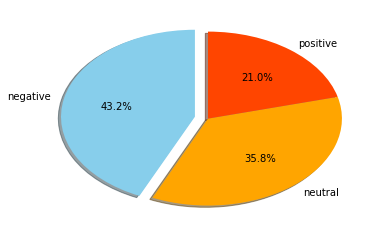

In [44]:
#analysis attitude of all tweets by using the aboved two libraries
import matplotlib.pyplot as plt
#from TwitterPlot import generic_pie_plot
%pylab inline
import nltk
from nltk import word_tokenize
nltk.download('punkt')

def load_data(filename):
    f = open(filename,'r', encoding='utf-8').read()
    content_json = json.loads(f)
    return content_json

def estimate_features(data, negative_words, positive_words):
    data_strings = []
    for tweet in data:
        if "lang" in tweet.keys() and tweet["lang"]=="en" and "text" in tweet.keys() and len(tweet["text"])!=0:
            data_strings.append(tweet["text"])
    scores_map = {}
    for sentence in data_strings:
        score = 0
        words_list = word_tokenize(sentence)
        for word in words_list:
            if word in negative_words:
                score -= 1
            if word in positive_words:
                score += 1
        scores_map[score] = scores_map.get(score, 0) + 1
    sorted_scores = sorted(scores_map.items(), key=lambda t: t[0], reverse=True)
    return sorted_scores

def positive_negative_map(score_map):
        p_n_map = {"positive":0, "negative":0, "neutral":0}
        for pair in score_map:
            if pair[0]>0:
                p_n_map["positive"] += pair[1]
            elif pair[0] == 0:
                p_n_map["neutral"] += pair[1]
            else:
                p_n_map["negative"] += pair[1]
        generic_pie_plot(p_n_map, num_shown=3, include_others=False)
 
negative_words = load_data("negative_words_cleaned.json")
positive_words = load_data("positive_words_cleaned.json")
data_strings = statuses

score_map = estimate_features(data_strings, negative_words, positive_words)
positive_negative_map(score_map)

In [2]:
# Finding top 20 cities that tweets were sent from

import json

with open('ryanair_6000.txt') as f:
    all_content = f.read()
all_list = json.loads(all_content)
print('len:', len(all_list))
new_list = []
for item in all_list:
    new_dict = {}
    for key in ['created_at', 'source', 'favorited', 'retweeted']:# 'quote_count', 'reply_count', 'retweet_count', 'favorite_count']:
        new_dict[key] = item[key]
    if item['place'] is not None:
        #try:
        new_dict['place_place_type'] = item['place']['place_type']
        new_dict['place_city_name'] = item['place']['name']
        new_dict['place_country'] = item['place']['country']
        #except:
        #    print(json.dumps(item, indent=4))
        #    break
    else:
        new_dict['place_place_type'] = None
        new_dict['place_city_name'] = None
        new_dict['place_country'] = None
        
    if 'retweeted_status' in item:
        for key in ['quote_count', 'reply_count', 'retweet_count', 'favorite_count']:
            new_dict[key] = item['retweeted_status'][key]
    else:
        for key in ['quote_count', 'reply_count', 'retweet_count', 'favorite_count']:
            new_dict[key] = -1
        

    new_dict['user_location'] = item['user']['location']
    new_list.append(new_dict)


# save
with open('ryanair_6000_choose.txt', 'w') as f:
    f.write(json.dumps(new_list, indent=4))

# reopen and use
with open('ryanair_6000_choose.txt') as f:
    all_content = f.read()
all_list = json.loads(all_content)

all_create_at_list = [item['created_at'] for item in all_list]
all_place_city = [item['place_city_name'] for item in all_list]
all_place_country = [item['place_country'] for item in all_list]

from collections import Counter
c = Counter(all_place_city)
print((c.most_common()[:20]))
# loop use
for item in [all_place_city, all_place_country, ]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10



len: 6000
[(None, 5840), ('Dublin City', 11), ('East', 5), ('London Stansted Airport - STN', 4), ('Sheffield', 4), ('Manchester', 3), ('Louth', 3), ('Lux', 3), ('Northern Ireland', 3), ('Camden Town', 2), ('South Dublin', 2), ('Stone', 2), ('Dorking', 2), ('Lewes', 2), ('Hetton', 2), ('Hilltown', 2), ('Brent', 2), ('Meath', 2), ('Edinburgh', 2), ('Blagnac', 2)]
[(None, 5840), ('Dublin City', 11), ('East', 5), ('London Stansted Airport - STN', 4), ('Sheffield', 4), ('Manchester', 3), ('Louth', 3), ('Lux', 3), ('Northern Ireland', 3), ('Camden Town', 2)]
[(None, 5840), ('United Kingdom', 72), ('Ireland', 26), ('France', 11), ('United States', 6), ('Italia', 5), ('Reino Unido', 5), ('Portugal', 4), ('Spain', 3), ('Germany', 3)]


# Plotting

In [3]:
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
from bokeh.charts import Bar, show
from prettytable import PrettyTable
from collections import Counter
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

#Plot top 20 cities of twitter
pt = PrettyTable(field_names=['City', 'Count'])
city = Counter(all_place_city).most_common()
[ pt.add_row(i) for i in city[:20] ]
pt.align['City'], pt.align['Count'] = 'l', 'r' # Set column alignment
print(str("Top 20 Cities:"),"\n")
print(pt)



Top 20 Cities: 

+-------------------------------+-------+
| City                          | Count |
+-------------------------------+-------+
| None                          |  5840 |
| Dublin City                   |    11 |
| East                          |     5 |
| London Stansted Airport - STN |     4 |
| Sheffield                     |     4 |
| Manchester                    |     3 |
| Louth                         |     3 |
| Lux                           |     3 |
| Northern Ireland              |     3 |
| Camden Town                   |     2 |
| South Dublin                  |     2 |
| Stone                         |     2 |
| Dorking                       |     2 |
| Lewes                         |     2 |
| Hetton                        |     2 |
| Hilltown                      |     2 |
| Brent                         |     2 |
| Meath                         |     2 |
| Edinburgh                     |     2 |
| Blagnac                       |     2 |
+----------------

In [6]:
#plot top 10 countries of twitter
country = [item['place_country'] for item in all_list]
c = Counter(country)
c_stat = c.most_common()[0:10]
country_count_dict = {
    'count': [item[1] for item in c.most_common()[0:10]],
    'country': [item[0] for item in c_stat]
}
df_country = pd.DataFrame(country_count_dict)
cp = Bar(df_country,'country',values = 'count', title = 'Distribution of Countries')
cp.legend.location = None
show(cp)
#the output for piece of code opens up in a new tab and will show only when its run so we have included this graph 
#in the report

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "ipython notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.


* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . We will ask two teams which are randomly selected to present their case studies in class for this case study. 

* ** Report**: please prepare a report (less than 10 pages) to report what you found in the data.
    * What data you collected? 
    * Why this topic is interesting or important to you? (Motivations)
    * How did you analyse the data?
    * What did you find in the data? 
 
     (please include figures or tables in the report, but no source code)

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through email to Prof. Paffenroth (rcpaffenroth@wpi.edu) *and* the TA Yingnan Liu (yliu18@wpi.edu).

#### We auto-process the submissions so make sure your subject line is *exactly*:

### DS501 Case Study 1 Team ??

#### where ?? is your team number.
        
** Note: Each team just needs to submits one submission **

# Grading Criteria:

** Totoal Points: 120 **


---------------------------------------------------------------------------
** Notebook:  **
    Points: 80


    -----------------------------------
    Qestion 1:
    Points: 20
    -----------------------------------
    
    (1) Select a topic that you are interested in.
    Points: 6 
    
    (2) Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million. Please check whether the total number of tweets collected is larger than 200?
    Points: 10 
    
    
    (3) Store the tweets you downloaded into a local file (txt file or json file)
    Points: 4 
    
    
    -----------------------------------
    Qestion 2:
    Points: 20
    -----------------------------------
    
    1. Word Count

    (1) Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets.
    Points: 4 

    (2) Plot a table of the top 30 words with their counts 
    Points: 4 
    
    2. Find the most popular tweets in your collection of tweets
    plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.
    Points: 4 
    
    3. Find the most popular Tweet Entities in your collection of tweets

    (1) plot a table of the top 10 hashtags, 
    Points: 4 

    (2) top 10 user mentions that are the most popular in your collection of tweets.
    Points: 4 
    
    
    -----------------------------------
    Qestion 3:
    Points: 20
    -----------------------------------
    
    (1) choose a popular twitter user who has many followers, such as "ladygaga".
    Points: 4 

    (2) Get the list of all friends and all followers of the twitter user.
    Points: 4 

    (3) Plot 20 out of the followers, plot their ID numbers and screen names in a table.
    Points: 4 

    (4) Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.
    Points: 4 
    
    (5) Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table
    Points: 4 
  
    -----------------------------------
    Qestion 4:  Business question
    Points: 20
    -----------------------------------
        Novelty: 10
        Interestingness: 10
    -----------------------------------
    Run some additional experiments with your data to gain familiarity with the twitter data ant twitter API.  Come up with a business question and describe how Twitter data can help you answer that question.




---------------------------------------------------------------------------
** Report: communicate the results**
    Points: 20

(1) What data you collected?
    Points: 5 

(2) Why this topic is interesting or important to you? (Motivations)
    Points: 5 

(3) How did you analyse the data?
    Points: 5 

(4) What did you find in the data?
(please include figures or tables in the report, but no source code)
    Points: 5 



---------------------------------------------------------------------------
** Slides (for 10 minutes of presentation): Story-telling **
    Points: 20


1. Motivation about the data collection, why the topic is interesting to you.
    Points: 5 

2. Communicating Results (figure/table)
    Points: 10 

3. Story telling (How all the parts (data, analysis, result) fit together as a story?)
    Points: 5 

